In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
import tensorflow 

In [ ]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
from simple_multi_unet_model import multi_unet_model #Uses softmax 

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
import splitfolders

# from keras.utils import normalize
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [ ]:
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

framObjTest = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
  image_names = glob.glob(imgPath)
  image_names.sort()
  train_images=[]
  for image in image_names:
    img=plt.imread(image)
    img = cv2.resize(img, (shape, shape))
    train_images.append(img)

  mask_names = glob.glob(maskPath)
  mask_names.sort()
  train_masks = [] 
  for maskpath in mask_names:
    mask = plt.imread(maskpath)       
    mask = cv2.resize(mask, (shape, shape), interpolation = cv2.INTER_NEAREST)  
    train_masks.append(mask)


  for i in range (len(train_images)):  
    frameObj['img'].append(train_images[i])
    frameObj['mask'].append(train_masks[i])
    
  return frameObj

        

In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = '/content/gdrive/My Drive/data3/train/*', maskPath = '/content/gdrive/My Drive/data3/train_labels/*', shape = 256)

In [ ]:
framObjValidation  = LoadData( framObjValidation, imgPath = '/content/gdrive/My Drive/data3/val/*', maskPath = '/content/gdrive/My Drive/data3/val_labels/*'
         , shape = 256)

In [ ]:
framObjTest  = LoadData( framObjTest, imgPath = '/content/gdrive/My Drivedata3/test/*', maskPath = '/content/gdrive/My Drive/data3/test_labels/*'
         , shape = 256)

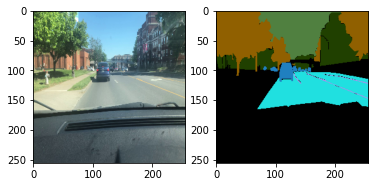

In [ ]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][0])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][0])
plt.show()

In [ ]:
framObjTrain['img'][0].shape

(256, 256, 3)

In [ ]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
## trainign our model
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 50, verbose = 1)

Epoch 1/50
17/17 [==============================] - 24s 268ms/step - loss: 0.5679 - accuracy: 0.3107
Epoch 2/50
17/17 [==============================] - 3s 202ms/step - loss: 0.4540 - accuracy: 0.3873
Epoch 3/50
17/17 [==============================] - 3s 202ms/step - loss: 0.4061 - accuracy: 0.3512
Epoch 4/50
17/17 [==============================] - 3s 202ms/step - loss: 0.3762 - accuracy: 0.3674
Epoch 5/50
17/17 [==============================] - 3s 202ms/step - loss: 0.3564 - accuracy: 0.3605
Epoch 6/50
17/17 [==============================] - 3s 202ms/step - loss: 0.3422 - accuracy: 0.3558
Epoch 7/50
17/17 [==============================] - 3s 202ms/step - loss: 0.3307 - accuracy: 0.3574
Epoch 8/50
17/17 [==============================] - 3s 202ms/step - loss: 0.3225 - accuracy: 0.3564
Epoch 9/50
17/17 [==============================] - 3s 202ms/step - loss: 0.3153 - accuracy: 0.3590
Epoch 10/50
17/17 [==============================] - 3s 202ms/step - loss: 0.3099 - accuracy: 0.364

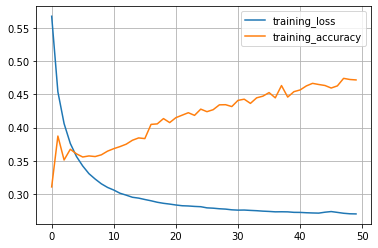

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:60]
    
    imgProc = img [0:60]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(12,12))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [ ]:
# myTransformer.save('unet_cam_model1.hdf5') #first model with new dataset using resnext backbone

In [ ]:
myTransformer=load_model('unet_cam_model1.hdf5', compile=False)

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, myTransformer)

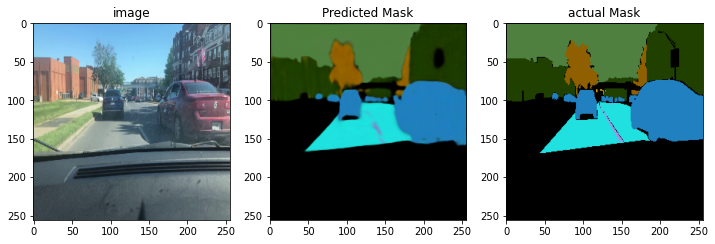

In [ ]:
import random
test_img_number = random.randint(1, 55)
Plotter(actuals[test_img_number], sixteenPrediction[test_img_number], masks[test_img_number])

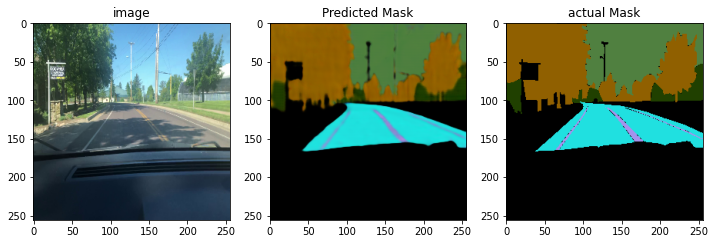

In [ ]:
Plotter(actuals[50], sixteenPrediction[50], masks[50])

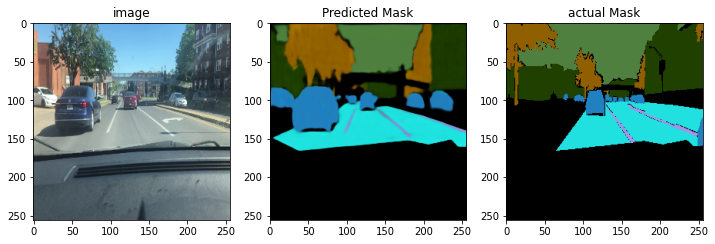

In [ ]:
Plotter(actuals[10], sixteenPrediction[10], masks[0])

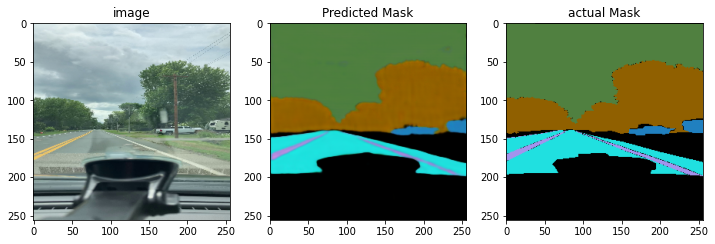

In [ ]:
import random
test_img_number = random.randint(1, 55)
Plotter(actuals[test_img_number], sixteenPrediction[test_img_number], masks[test_img_number])

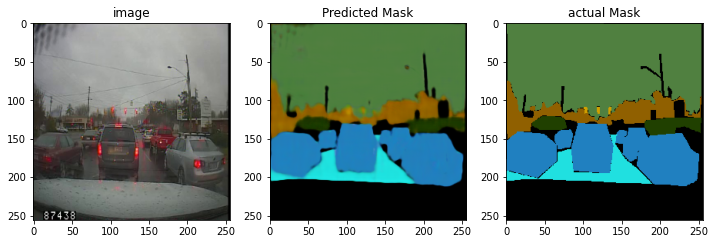

In [ ]:
import random
test_img_number = random.randint(1, 55)
Plotter(actuals[test_img_number], sixteenPrediction[test_img_number], masks[test_img_number])

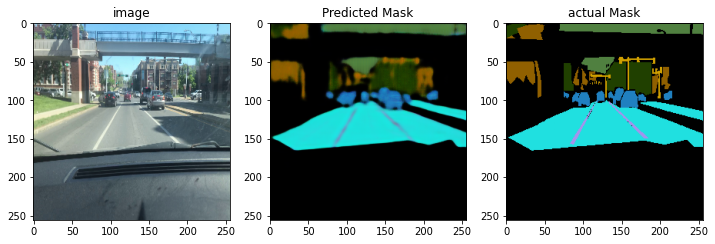

In [ ]:
import random
test_img_number = random.randint(1, 55)
Plotter(actuals[test_img_number], sixteenPrediction[test_img_number], masks[test_img_number])

In [ ]:
sixteenPrediction1, actuals1, masks1 = predict16(framObjTest, myTransformer)

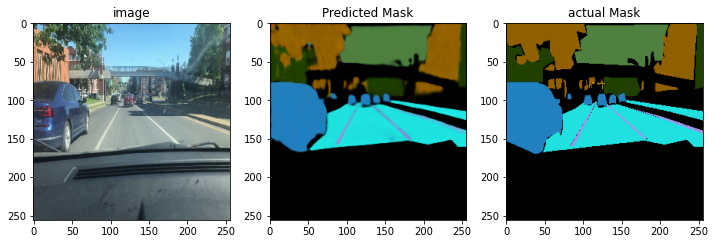

In [ ]:
import random
test_img_number = random.randint(1, 55)
Plotter(actuals1[test_img_number], sixteenPrediction1[test_img_number], masks1[test_img_number])

In [ ]:
#sixteenPrediction1[0]

In [ ]:
# while True:
#   pass